# QDM-QPLAD EDA

This notebook is for exploring the Quantile Delta Mapping - Quantile Preserving Analog Downscaling method. This method of statistical downscaling, introduced in [Gergel et al. 2023](https://doi.org/10.5194/gmd-17-191-2024), is of interest to collaborators, and this notebook will attempt to implement this method as a proof of concept for our CMIP6 statistical downscaling goals.  

The code used to do it is in a fork of the `xclim` package developed by the team who created this method: [https://github.com/ClimateImpactLab/xclim](https://github.com/ClimateImpactLab/xclim). 

The [ClimateImpactLab/dodola](https://github.com/ClimateImpactLab/dodola) repo contains the python code used to actually perform the downscaling. 

### Environment

This is an experimental notebook, and will use their forked version of `xclim`. The spec for the environment used to run this notebook on a Chinook compute node can be found in the `cil_xclim_env.yml` file, and you can create the environment by running `conda env create -f cil_xclim_env.yml`. 

If you are unable to load the `xclim` functionality specific to the CIL-forked version, it's possible that `pip` installed from PyPI - I'm not sure how to set a github repo in the env spec file. Just install using `pip` like so:

```
pip install git+https://github.com/ClimateImpactLab/xclim@master
```

### ERA5 daily data

We will also need ERA5 data at the daily resolution. Since the WRF simulations are done at an hourly frequency, we will need to resample that hourly data to the daily scale. Use the `resample_era5.py` and the `run_resample_era5.slurm` scripts in this folder to achieve this. 

### Regridding ERA5

We need that ERA5 data regridded in a couple of different ways. See the `regridding.ipynb` notebook in this folder to do that

## QDM adjustment

Now we will try first adjusting some GCM data.

From the paper:

> GCM projections for each variable, GCM, experiment, pixel, year, and day at a 1◦ × 1◦ resolution are bias-adjusted using the xclim Python package QDM implementation (Logan et al., 2021). To do this, QDM models for each pixel and day of the year are trained on a rolling 31 d centered window (±15 d) of daily ERA5 and GCM historical data from 1995 to 2014. For ERA5 reference data, we include the last 15 d from 1994 and the first 15 d from 2015, such that each day group contains 620 values (20 years × 31 d). For CMIP6 historical data, since the simulation ends in 2014, we do not include the additional 15 d from 2015 or 1994 for consistency. Each trained QDM model (per pixel and day of year) has 100 equally spaced quantiles in our implementation. We used an additive adjustment for maximum and minimum temperature and a multiplicative adjustment for precipitation. Each variable was bias-adjusted separately.

So, we will first need to load and regrid daily ERA5 data to the common grid. We will use the daily data created with the scripts referenced in the beginning of this notebook. 

In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import xclim
from xclim import sdba, set_options
from xclim.sdba.utils import equally_spaced_nodes
from dask.distributed import LocalCluster, Client

# downscaling project directory for writing inputs/outputs
downscaling_dir = Path("/beegfs/CMIP6/kmredilla/downscaling")

Spin up a dask cluster:

In [2]:
# The threads_per_worker=1 seems to have really helped with open_mfdataset()
cluster = LocalCluster(n_workers=8)
client = Client(cluster)
client

2024-10-11 15:51:02,972 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-kdksyv1d', purging
2024-10-11 15:51:02,973 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-xne4vl8d', purging
2024-10-11 15:51:02,973 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-im3tberh', purging
2024-10-11 15:51:02,973 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-rm4kk7z4', purging
2024-10-11 15:51:02,973 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-owrwvzc1', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 48,Total memory: 251.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33991,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 251.56 GiB
Comm: tcp://127.0.0.1:40577,Total threads: 6
Dashboard: http://127.0.0.1:39071/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:40857,


Load up the common grid ERA5 dataset, this will be our reference dataset

In [3]:
ref_ds = xr.open_mfdataset(downscaling_dir.joinpath("era5_common.nc"))
# use consistent names with the CMIP6 data
ref_ds = ref_ds.rename({"t2max": "tasmax"})
ref_da = ref_ds["tasmax"].chunk({"lat": 20, "lon": 20})
ref_da

<xarray.DataArray 'tasmax' (time: 7335, lat: 43, lon: 288)>
dask.array<rechunk-merge, shape=(7335, 43, 288), dtype=float32, chunksize=(7335, 20, 20), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1994-12-17 1994-12-18 ... 2015-01-15
  * lat          (lat) float64 90.0 89.06 88.12 87.17 ... 53.25 52.3 51.36 50.42
  * lon          (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
    spatial_ref  int64 ...
Attributes:
    regrid_method:  bilinear

Since much of this domain is NaN, we can subset down to the minimum bbox containing the ERA5 data:

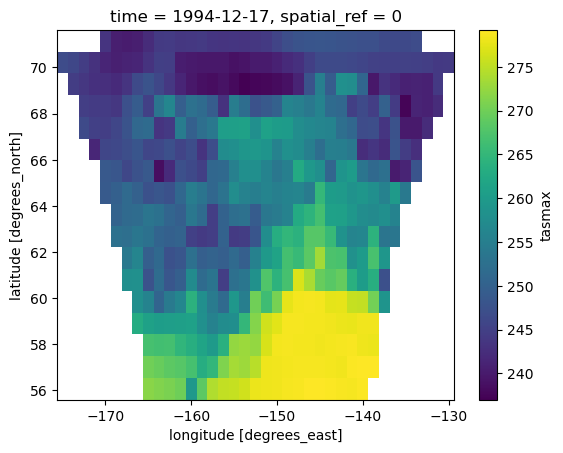

In [4]:
sel_di = dict(lon=slice(-176, -129), lat=slice(72, 55.5))
ref_da = ref_da.sel(sel_di)
ref_da.isel(time=0).plot()

Convert the calendar of ERA5 to noleap to match the CMIP6 calendars and convert from kelvin to celsius:

In [5]:
ref_da = ref_da.convert_calendar("noleap")
ref_da.attrs["units"] = "K"
ref_da = xclim.units.convert_units_to(ref_da, "degC")

Now we can load some CMIP6 data to be adjusted. We will load some historical tasmax data from the GFDL-ESM4 model for the same years:

In [6]:
hist_dir = Path(
    "/beegfs/CMIP6/kmredilla/cmip6_regridding/regrid/GFDL-ESM4/historical/day/tasmax"
)
hist_fps = []
for year in range(1995, 2015):
    hist_fps.extend(sorted(hist_dir.glob(f"*{year}0101*.nc")))

hist_ds = xr.open_mfdataset(hist_fps).transpose("time", "lat", "lon")
hist_da = hist_ds["tasmax"].sel(sel_di).chunk({"time": -1, "lat": 20, "lon": 20})

Now we can run QDM training:

In [7]:
window_n = 31
quantiles_n = 100
kind = "+"
grouper = sdba.Grouper("time.dayofyear", window=int(window_n))

qdm = sdba.adjustment.QuantileDeltaMapping.train(
    ref=ref_da,
    hist=hist_da,
    kind=kind,
    group=grouper,
    nquantiles=equally_spaced_nodes(int(quantiles_n), eps=None),
)

And adjust:

In [8]:
year = 2000
halfyearwindow_n = 10

if isinstance(qdm, xr.Dataset):
    qdm = sdba.adjustment.QuantileDeltaMapping.from_dataset(qdm)

# Slice to get 15 days before and after our target year. This accounts
# for the rolling 31 day rolling window.
timeslice = slice(
    f"{year - halfyearwindow_n - 1}-12-17", f"{year + halfyearwindow_n + 1}-01-15"
)
simulation = hist_da.sel(
    time=timeslice
)  # TODO: Need a check to ensure we have all the data in this slice!

with set_options(sdba_extra_output=True):
    hist_adj = qdm.adjust(simulation, interp="nearest").sel(time=str(year))
    # make quantiles a coordinate of bias corrected output variable
    hist_adj = hist_adj["scen"].assign_coords(sim_q=hist_adj.sim_q)

hist_adj = hist_adj.to_dataset(name="tasmax").transpose("time", "lat", "lon")
hist_adj.load()

<xarray.Dataset>
Dimensions:      (lat: 17, time: 365, lon: 37)
Coordinates:
  * lat          (lat) float64 71.15 70.21 69.27 68.32 ... 57.96 57.02 56.07
  * time         (time) object 2000-01-01 12:00:00 ... 2000-12-31 12:00:00
  * lon          (lon) float64 -175.0 -173.8 -172.5 ... -132.5 -131.2 -130.0
    spatial_ref  int64 0
    height       float64 2.0
    sim_q        (time, lat, lon) float64 0.4118 0.4118 0.4118 ... 0.9375 0.9375
Data variables:
    tasmax       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

Save the adjusted output, as we will need to re-grid this to the target grid:

In [9]:
hist_adj_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted.nc"
)
# having issues overwriting file if it exists?
hist_adj_fp.unlink()
hist_adj.to_netcdf(hist_adj_fp)

Alright, well it looks like that worked. 

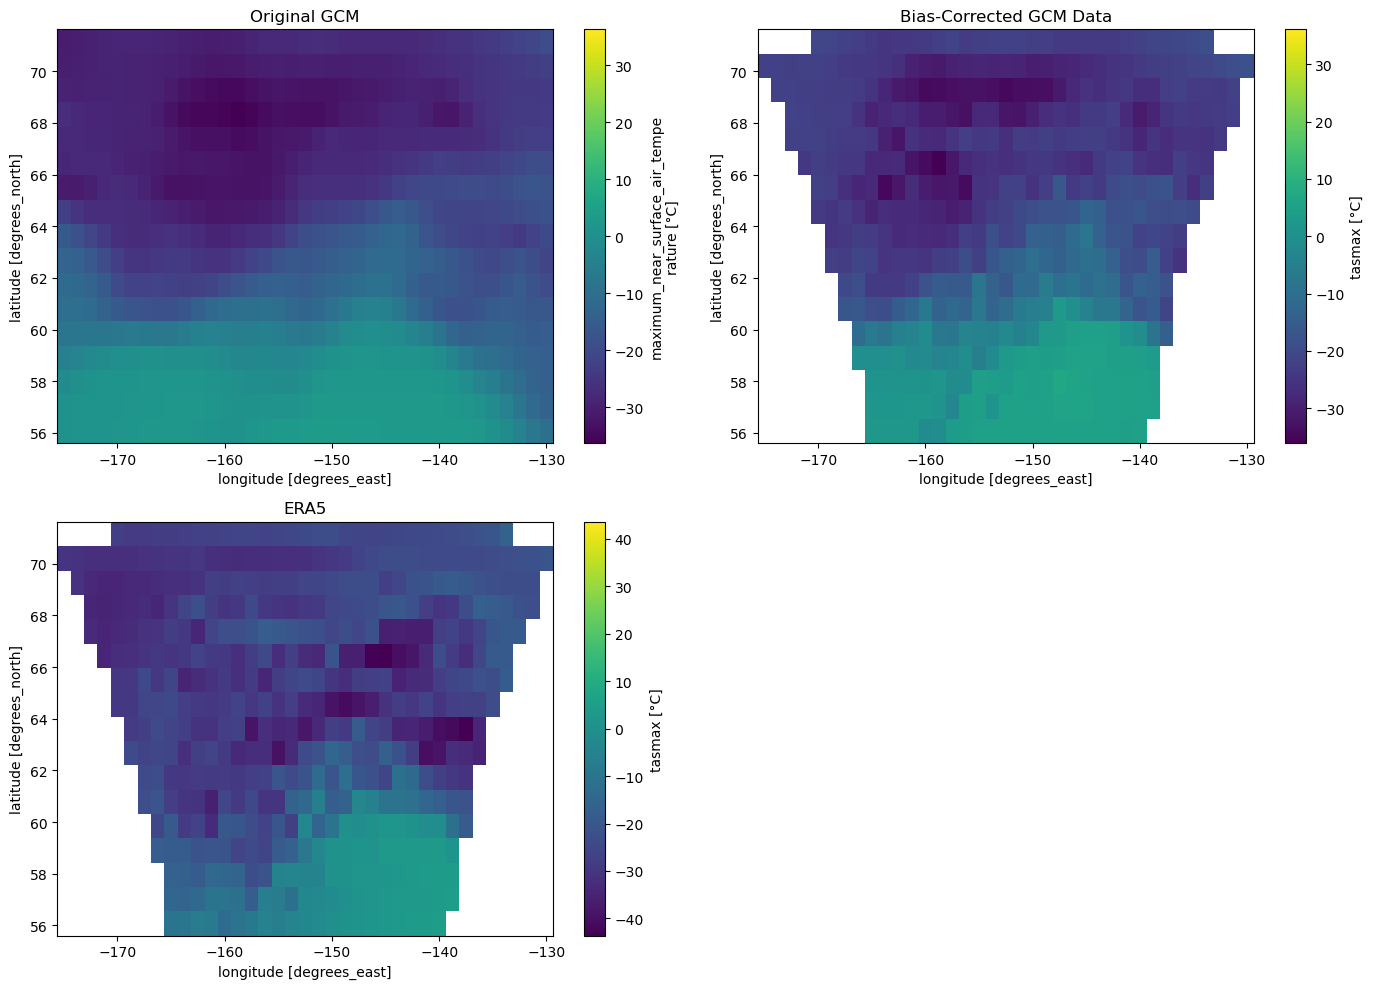

In [10]:
import matplotlib.pyplot as plt

# Select a time slice
time_index = 0  # Change this index to select a different time slice

# Plot the time slice from hist_da
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

hist_da.sel(time="2000-01-01").plot(ax=axes[0][0], cmap="viridis")
axes[0][0].set_title("Original GCM")

# Plot the time slice from hist_qdm
hist_adj["tasmax"].sel(time="2000-01-01").plot(ax=axes[0][1], cmap="viridis")
axes[0][1].set_title("Bias-Corrected GCM Data")

ref_da.sel(time="2000-01-01").plot(ax=axes[1][0], cmap="viridis")
axes[1][0].set_title("ERA5")

fig.delaxes(axes[1][1])

plt.tight_layout()
plt.show()

## QPLAD downscaling

Here are some functions pulled from the dodola repo used to set up the CLI pieces for the pipeline workflow. 

Below are some functions that are pulled from the [dodola repo](https://github.com/ClimateImpactLab/dodola), which is the "Containerized application for running individual tasks in a larger, orchestrated CMIP6 bias-adjustment and downscaling workflow." We will pull some of the code out from these functions to experiment with. 

In [ ]:
def train_analogdownscaling(
    coarse_reference, fine_reference, variable, kind, quantiles_n=620, window_n=31
):
    """Train Quantile-Preserving, Localized Analogs Downscaling (QPLAD)

    Parameters
    ----------
    coarse_reference : xr.Dataset
        Dataset to use as resampled (to fine resolution) coarse reference.Target variable must have a units attribute.
    fine_reference : xr.Dataset
        Dataset to use as fine-resolution reference. Target variable must have a units attribute.
    variable : str
        Name of target variable to extract from `coarse_reference` and `fine_reference`.
    kind : {"+", "*"}
        Kind of variable. Used for creating QPLAD adjustment factors.
    quantiles_n : int, optional
        Number of quantiles for QPLAD.
    window_n : int, optional
        Centered window size for day-of-year grouping.

    Returns
    -------
    xclim.sdba.adjustment.QuantilePreservingAnalogDownscaling
    """

    # QPLAD method requires that the number of quantiles equals
    # the number of days in each day group
    # e.g. 20 years of data and a window of 31 = 620 quantiles

    # check that lengths of input data are the same, then only check years for one
    if len(coarse_reference.time) != len(fine_reference.time):
        raise ValueError("coarse and fine reference data inputs have different lengths")

    # check number of years in input data (subtract 2 for the +/- 15 days on each end)
    num_years = len(np.unique(fine_reference.time.dt.year)) - 2
    if (num_years * int(window_n)) != quantiles_n:
        raise ValueError(
            "number of quantiles {} must equal # of years {} * window length {}, day groups must {} days".format(
                quantiles_n, num_years, int(window_n), quantiles_n
            )
        )

    qplad = sdba.adjustment.QuantilePreservingAnalogDownscaling.train(
        ref=coarse_reference[variable],
        hist=fine_reference[variable],
        kind=str(kind),
        group=sdba.Grouper("time.dayofyear", window=int(window_n)),
        nquantiles=quantiles_n,
    )
    return qplad


def adjust_analogdownscaling(simulation, qplad, variable):
    """Apply QPLAD to downscale bias corrected output.

    Parameters
    ----------
    simulation : xr.Dataset
        Daily bias corrected data to be downscaled. Target variable must have a units attribute.
    qplad : xr.Dataset or sdba.adjustment.QuantilePreservingAnalogDownscaling
        Trained ``xclim.sdba.adjustment.QuantilePreservingAnalogDownscaling``, or
        Dataset representation that will instantiate
        ``xclim.sdba.adjustment.QuantilePreservingAnalogDownscaling``.
    variable : str
        Target variable in `simulation` to downscale. Downscaled output will share the
        same name.

    Returns
    -------
    out : xr.Dataset
        QPLAD-downscaled values from `simulation`. May be a lazy-evaluated future, not
        yet computed.
    """
    variable = str(variable)

    if isinstance(qplad, xr.Dataset):
        qplad = sdba.adjustment.QuantilePreservingAnalogDownscaling.from_dataset(qplad)

    out = qplad.adjust(simulation[variable]).to_dataset(name=variable)

    out = out.transpose(*simulation[variable].dims)
    # Overwrite QPLAD output attrs with input simulation attrs.
    out.attrs = simulation.attrs
    for k, v in simulation.variables.items():
        if k in out:
            out[k].attrs = v.attrs

    return out

First we should load up the coarse and fine reference datasets - the ERA5 data on the target grid - and make the same tweaks to prep it:

In [17]:
coarse_ref_ds = xr.open_mfdataset(downscaling_dir.joinpath("era5_coarse.nc")).rename(
    {"t2max": "tasmax"}
)
# use consistent names with the CMIP6 data
coarse_ref_da = coarse_ref_ds["tasmax"].chunk({"x": 10, "y": 10})
coarse_ref_da = coarse_ref_da.convert_calendar("noleap")
coarse_ref_da.attrs["units"] = "K"
coarse_ref_da = xclim.units.convert_units_to(coarse_ref_da, "degC")

coarse_ref_da

<xarray.DataArray 'tasmax' (time: 7330, y: 460, x: 443)>
dask.array<truediv, shape=(7330, 460, 443), dtype=float32, chunksize=(7330, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) object 1994-12-17 00:00:00 ... 2015-01-15 00:00:00
    spatial_ref  int64 0
  * x            (x) float64 -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y            (y) float64 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05
    lon          (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear
    units:          °C

In [18]:
fine_ref_da = xr.open_mfdataset(downscaling_dir.joinpath("era5_fine.nc")).rename(
    {"t2max": "tasmax"}
)
# use consistent names with the CMIP6 data
fine_ref_da = fine_ref_da["tasmax"].chunk({"x": 10, "y": 10})
fine_ref_da = fine_ref_da.convert_calendar("noleap")
fine_ref_da.attrs["units"] = "K"
fine_ref_da = xclim.units.convert_units_to(fine_ref_da, "degC")

fine_ref_da

<xarray.DataArray 'tasmax' (time: 7330, y: 460, x: 443)>
dask.array<truediv, shape=(7330, 460, 443), dtype=float32, chunksize=(7330, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y        (y) float64 2.476e+06 2.472e+06 2.468e+06 ... 6.402e+05 6.362e+05
  * time     (time) object 1994-12-17 00:00:00 ... 2015-01-15 00:00:00
Attributes:
    coordinates:   lat lon
    grid_mapping:  spatial_ref
    units:         °C

Now train the downscaling object:

In [19]:
# QPLAD method requires that the number of quantiles equals
# the number of days in each day group
# e.g. 20 years of data and a window of 31 = 620 quantiles

assert len(coarse_ref_da.time) == len(fine_ref_da.time)
quantiles_n = 620

# check number of years in input data (subtract 2 for the +/- 15 days on each end)
num_years = len(np.unique(fine_ref_da.time.dt.year)) - 2

assert (num_years * int(window_n)) == quantiles_n

In [20]:
qplad = sdba.adjustment.QuantilePreservingAnalogDownscaling.train(
    ref=coarse_ref_da,
    hist=fine_ref_da,
    kind=kind,
    group=grouper,
    nquantiles=quantiles_n,
)

2024-10-11 15:53:33,466 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-10-11 15:53:34,264 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-10-11 15:53:35,063 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2024-10-11 15:53:35,858 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2024-10-11 15:53:36,640 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2024-10-11 15:53:37,425 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2024-10-11 15:53:38,215 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2024-10-11 15:53:39,002 - distributed.utils_perf - WARNING - full garbage collections took

In [21]:
hist_adj_fine_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted_fine.nc"
)
hist_adj_fine = xr.open_dataset(hist_adj_fine_fp, engine="h5netcdf")

In [22]:
hist_qplad = qplad.adjust(hist_adj_fine.set_coords(["sim_q"])["tasmax"])

2024-10-11 15:54:06,934 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2024-10-11 15:54:09,211 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2024-10-11 15:54:11,962 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2024-10-11 15:54:16,980 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-10-11 15:54:20,784 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-10-11 15:55:32,177 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2024-10-11 15:55:33,549 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)


2024-10-11 15:54:15,778 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-10-11 15:54:26,695 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


In [24]:
hist_qplad.isel(time=0).plot()

2024-10-11 15:54:40,815 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-10-11 15:54:42,933 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-10-11 15:54:47,808 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-10-11 15:54:49,430 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-10-11 15:54:51,042 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-10-11 15:54:52,669 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-10-11 15:54:54,210 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-10-11 15:54:55,814 - distributed.utils_perf - WARNING - full garbage collections took

ValueError: group_qplad_train failed on block with coords : Coordinates:
  * time     (time) object 1994-12-17 00:00:00 ... 2015-01-15 00:00:00
  * x        (x) float64 -3.066e+05 -3.025e+05 ... -2.745e+05 -2.705e+05
  * y        (y) float64 6.723e+05 6.683e+05 6.643e+05 ... 6.402e+05 6.362e+05.

2024-10-11 15:56:09,846 - distributed.worker - ERROR - Exception during execution of task ('getitem-fff247d58c100afc6b6d9bbbf7c053de', 0, 16, 2).
Traceback (most recent call last):
  File "/home/kmredilla/miniconda3/envs/cil-xclim/lib/python3.9/site-packages/zict/buffer.py", line 184, in __getitem__
    return self.fast[key]
  File "/home/kmredilla/miniconda3/envs/cil-xclim/lib/python3.9/site-packages/zict/common.py", line 127, in wrapper
    return func(*args, **kwargs)
  File "/home/kmredilla/miniconda3/envs/cil-xclim/lib/python3.9/site-packages/zict/lru.py", line 117, in __getitem__
    result = self.d[key]
KeyError: "('rechunk-merge-rechunk-split-getitem-fff247d58c100afc6b6d9bbbf7c053de', 0, 16, 2)"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/kmredilla/miniconda3/envs/cil-xclim/lib/python3.9/site-packages/distributed/worker.py", line 2367, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/ho

In [42]:
out = qplad.adjust(hist_adj)

out = out.transpose(*simulation[variable].dims)
# Overwrite QPLAD output attrs with input simulation attrs.
out.attrs = simulation.attrs
for k, v in simulation.variables.items():
    if k in out:
        out[k].attrs = v.attrs

xclim.sdba.adjustment.QuantilePreservingAnalogDownscaling